In [1]:
import time
from typing import Any, Sequence, Mapping

In [2]:
# example of fitting a gaussian mixture model with expectation maximization
import numpy as np
from sklearn import mixture
from scipy import stats
from scipy import linalg
from sklearn import model_selection
import pandas as pd
import gymnasium as gym

In [3]:
from rlplg.environments import gridworld, iceworld, redgreen

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
def mv_normal(mu, eigenvalues):
    dim = len(mu)
    # ortho matrix
    ortho_matrix = stats.ortho_group.rvs(dim)
    # cov matrix; dim x dim
    cov = np.matmul(ortho_matrix, np.matmul(np.diag(eigenvalues), ortho_matrix.T))
    return stats.multivariate_normal(mu, cov)

In [6]:
def high_dim_data(dim: int, num_samples: int):
    mu = [np.random.rand()*np.random.randint(1, 100) for _ in range(dim)]
    eigenvalues = [np.random.rand()*np.random.randint(1, 1000) for _ in range(dim)]
    normal_dist = mv_normal(mu=mu, eigenvalues=eigenvalues)
    return normal_dist.rvs(size=num_samples)

In [7]:
def high_dim_mixture(X, num_components: int):
    # generate a sample
    # fit model
    model = mixture.GaussianMixture(
        n_components=num_components, init_params="k-means++", max_iter=1000
    )
    model.fit(X)
    return model

In [8]:
def solve_least_squares(
    matrix: np.ndarray, rhs: np.ndarray
) -> np.ndarray:
    try:
        solution, _, _, _ = linalg.lstsq(a=matrix, b=rhs, lapack_driver="gelsy")
        return solution  # type: ignore
    except linalg.LinAlgError as err:
        # the computation failed, likely due to the matix being unsuitable (no solution).
        raise ValueError("Failed to solve linear system") from err

In [9]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    return np.sqrt(
        np.sum(np.power(v_pred - v_true, 2.0), axis=axis) / np.shape(v_pred)[axis]
    )

## Random Data

In [10]:
X = high_dim_data(dim=2, num_samples=100_000)
y = X[:,0]*0.1 + X[:,1]*2 + 0.5

In [11]:
def random_data_rewards(X, y, delay: int, sample_size: int):
    # TODO: test dynamic delay
    mask = np.random.choice(len(X), (sample_size, delay))
    samples = np.sum(X[mask], axis=1) # batch x delay x dim -> batch x dim
    rewards = np.sum(y[mask], axis=1) # batch x delay -> batch
    return samples, rewards

In [12]:
X_delay, y_delay = random_data_rewards(X, y, delay=3, sample_size=10_000)

In [13]:
sol = solve_least_squares(X_delay, y_delay)

In [14]:
sol

array([0.10009598, 2.00789608])

In [15]:
X

array([[32.63741294, 65.12097201],
       [21.93920228, 56.96212008],
       [17.25028252, 45.2871161 ],
       ...,
       [21.53055161, 66.48357572],
       [34.01364423, 44.41442173],
       [43.28304729, 76.29534128]])

In [16]:
yhat = np.matmul(X, sol)

In [17]:
rmse(v_pred=yhat, v_true=y, axis=0)

0.07481751612143975

In [18]:
y[:10], yhat[:10]

(array([134.0056853 , 116.61816039,  92.79926045, 132.70151334,
        117.33864892, 120.65740085, 123.10862969, 119.68145221,
        131.89737928, 133.94478679]),
 array([134.02301807, 116.57004343,  92.65850671, 132.72217245,
        117.29152817, 120.62587312, 123.0777538 , 119.64792883,
        131.90942362, 133.96560714]))

## Gym Env

In [19]:
def collection_traj_data(env, steps: int):
    obs, _ = env.reset()
    step = 0
    buffer = []
    while step < steps:
        action = env.action_space.sample()
        next_obs, rew, term, trunc, _,  = env.step(action)
        step += 1
        buffer.append((obs, action, rew))
        obs = next_obs
        if term or trunc:
            obs, _ = env.reset()
    return buffer

In [20]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [21]:
def gm_proj(buffer, param_grid):
    obs = np.stack([example[0] for example in buffer])
    grid_search = model_selection.GridSearchCV(
        mixture.GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )
    return grid_search.fit(obs)

In [22]:
def delay_reward_data(buffer, proj_model, delay: int, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    obs_basis = proj_model.predict_proba(obs)
    # repr: (m1,a1)(m2,a1)..
    mdim = obs_basis.shape[1] * len(np.unique(action))
    num_components = obs_basis.shape[1]

    # build samples
    mask = np.random.choice(len(obs_basis), (sample_size, delay))
    delayed_obs = obs_basis[mask] # batch x delay x dim
    delayed_act = action[mask]
    delayed_rew = np.sum(reward[mask], axis=1) # batch x delay -> batch    
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        for j in range(delay):
            c = num_components*delayed_act[i][j]
            rhat_matrix[i,c:c+num_components] += delayed_obs[i][j]

    return rhat_matrix, delayed_rew

In [23]:
def proj_obs_to_rwest_vec(buffer, proj_model, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    obs_basis = proj_model.predict_proba(obs)
    # repr: (m1,a1)(m2,a1)..
    mdim = obs_basis.shape[1] * len(np.unique(action))
    num_components = obs_basis.shape[1]

    # build samples
    mask = np.random.choice(len(obs_basis), sample_size)
    delayed_obs = obs_basis[mask] # batch x dim
    delayed_act = action[mask] # batch
    delayed_rew = reward[mask] # batch
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        c = num_components*delayed_act[i]
        rhat_matrix[i,c:c+num_components] += delayed_obs[i]
    return rhat_matrix, delayed_rew

In [24]:
def solve_rwe(env: gym.Env, num_steps: int, sample_size: int, delay: int, param_grid: Mapping[str, Any]):
    buffer = collection_traj_data(env, steps=num_steps)
    gmp = gm_proj(buffer, param_grid=param_grid)
    print(gmp.best_estimator_)
    Xd, yd = delay_reward_data(buffer, gmp, delay=delay, sample_size=sample_size)
    return buffer, gmp, solve_least_squares(Xd, yd)

### Moutain Car

In [25]:
mc_env = gym.make("MountainCar-v0")
mc_buffer, mc_gmp, mc_sol = solve_rwe(
    mc_env,
    num_steps=100_000, 
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(2, 8),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

GaussianMixture(covariance_type='diag', n_components=3)


In [26]:
len(mc_buffer)

100000

In [27]:
mc_buffer[0]

(array([-0.4874499,  0.       ], dtype=float32), 0, -1.0)

In [28]:
mc_gmp

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(2, 8)},
             scoring=<function gmm_bic_score at 0x172a77560>)

In [29]:
mc_gmp.best_estimator_

GaussianMixture(covariance_type='diag', n_components=3)

In [30]:
mc_sol

array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [31]:
mc_eval_X, mc_eval_y = proj_obs_to_rwest_vec(mc_buffer, mc_gmp, sample_size=10_000)

The predicted reward for every state action pair is -1 which is correct.
Though for this problem, it's a constant for every state except the terminal state.

In [32]:
np.matmul(mc_eval_X, mc_sol)

array([-1., -1., -1., ..., -1., -1., -1.])

### Grid World (Different Rewards)

In [33]:
class GW2D(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(shape=(2,), low=-np.inf, high=np.inf)

    def observation(self, obs):
        # assume one exit
        # Option 1: 3D grid with agent, cliffs, exit (flattened)
        # Option 2: Deltas between agent and cliffs, and exit
        # TODO: experiment with different options
        # This is option 2
        return np.stack(
            [np.array(obs["agent"]) - np.array(obs["exits"][0])]
            + [np.array(obs["agent"]) - np.array(cliff) for cliff in obs["cliffs"]]
        ).flatten()

In [34]:
size, cliffs, exits, start = gridworld.parse_grid_from_text(
    "oooooooooooo\noooooooooooo\noooooooooooo\nsxxxxxxxxxxg"
)
gw_env = GW2D(gridworld.GridWorld(size, cliffs, exits, start))
gw_buffer, gw_gmp, gw_sol = solve_rwe(
    gw_env,
    num_steps=100_000, 
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(15, 20),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

GaussianMixture(covariance_type='tied', n_components=15)


In [35]:
gw_sol

array([ -0.50849798,  -0.41726523,  -2.20757081,  -0.70595931,
        -0.90512355,  -0.63435572,  -1.2197726 ,  -0.21442864,
        -1.17436786,  -0.94202063,  -1.68232153,  -0.6369447 ,
        -0.33647374,  -1.37149453,  -2.74005566,  -1.39772074,
        -1.37445078,  -0.52604332,  -1.72737333,  -1.84488521,
        -0.56058224,  -0.81306672,  -0.77829509,  -1.23492683,
        -2.75109968,  -1.6831699 ,  -0.16280812,  -0.96000677,
        -1.18606389,  -0.47255305,  -0.98632407,  -0.56363745,
        -2.36873713,  -1.49044333,  -0.59349575,  -0.42493856,
        -0.82676482,  -1.09601501,  -1.05122509,  -0.97806934,
        -1.02492734,  -1.00939668,  -0.71241989,  -0.45986535,
        -0.1827856 , -41.88463339,  -0.69949916,  -0.95700672,
        -1.2543576 ,  -3.97130937,  -0.82679532,  -1.19511883,
        -0.73709698,  -1.12051649,  -1.19893992,  -0.10339396,
        11.50415113,  -1.30350071,  -0.78466253,  -0.68626322])

In [36]:
gw_gmp

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(15, 20)},
             scoring=<function gmm_bic_score at 0x172a77560>)

In [37]:
gw_eval_X, gw_eval_y = proj_obs_to_rwest_vec(gw_buffer, gw_gmp, sample_size=10_000)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

<Axes: xlabel='reward', ylabel='Count'>

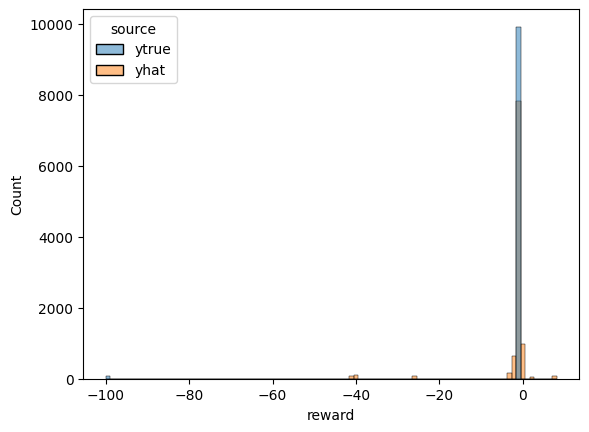

In [38]:
sns.histplot(
    pd.DataFrame({
        "reward": gw_eval_y.tolist() + np.matmul(gw_eval_X, gw_sol).tolist(),
        "source": ["ytrue"]*len(gw_eval_y) + ["yhat"]*len(gw_eval_X)
    }),
    x="reward",
    hue="source",
    bins=100
)

In [39]:
gw_eval_X.shape, gw_eval_y.shape

((10000, 60), (10000,))

In [40]:
rmse(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y,
    axis=0
)

6.841967988104735

In [41]:
np.unique(np.around(np.matmul(gw_eval_X, gw_sol), 2))

array([-4.161e+01, -3.953e+01, -2.632e+01, -3.120e+00, -2.930e+00,
       -2.570e+00, -2.390e+00, -2.210e+00, -2.110e+00, -2.030e+00,
       -2.010e+00, -1.960e+00, -1.930e+00, -1.820e+00, -1.760e+00,
       -1.710e+00, -1.600e+00, -1.590e+00, -1.580e+00, -1.560e+00,
       -1.550e+00, -1.490e+00, -1.470e+00, -1.440e+00, -1.400e+00,
       -1.390e+00, -1.370e+00, -1.350e+00, -1.340e+00, -1.330e+00,
       -1.300e+00, -1.290e+00, -1.280e+00, -1.250e+00, -1.240e+00,
       -1.230e+00, -1.220e+00, -1.200e+00, -1.190e+00, -1.180e+00,
       -1.170e+00, -1.160e+00, -1.150e+00, -1.140e+00, -1.120e+00,
       -1.110e+00, -1.100e+00, -1.080e+00, -1.070e+00, -1.060e+00,
       -1.050e+00, -1.040e+00, -1.030e+00, -1.010e+00, -1.000e+00,
       -9.900e-01, -9.800e-01, -9.600e-01, -9.500e-01, -9.400e-01,
       -9.300e-01, -9.100e-01, -9.000e-01, -8.900e-01, -8.800e-01,
       -8.700e-01, -8.600e-01, -8.500e-01, -8.400e-01, -8.300e-01,
       -8.200e-01, -8.100e-01, -8.000e-01, -7.900e-01, -7.800e

## RedGreen

In [42]:
class RG2D(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(shape=(2,), low=-np.inf, high=np.inf)

    def observation(self, obs):
        # assume one exit
        # Option 1: 3D grid with agent, cliffs, exit (flattened)
        # Option 2: Deltas between agent and cliffs, and exit
        # TODO: experiment with different options
        # This is option 2
        return np.array([obs["pos"], len(obs["cure_sequence"])])

In [43]:
rg_env = RG2D(redgreen.RedGreenSeq(["red", "green", "red", "green", "wait", "green"]))
rg_buffer, rg_gmp, rg_sol = solve_rwe(
    rg_env, 
    num_steps=100_000, 
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(2, 10),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6

GaussianMixture(covariance_type='tied', n_components=6)


In [44]:
rg_sol

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.])

## Lunda Lander

In [45]:
lunar_env = gym.make("LunarLander-v3")
lunar_buffer, lunar_gmp, lunar_sol = solve_rwe(
    lunar_env,
    num_steps=100_000,
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(2, 6),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

GaussianMixture(n_components=5)


In [46]:
lunar_sol

array([-23.87789278, -28.3867234 ,  -0.85672709,  -1.68687735,
       -15.54951704, -16.71424405, -16.092075  ,  -2.00116991,
        -0.85551326, -19.41889324, -23.8016924 , -15.48338885,
         0.46270559,  -0.71217171, -19.1988383 , -19.50686628,
       -17.32840054,  -0.67654319,  -2.47194257, -16.7261085 ])

In [47]:
lunar_eval_X, lunar_eval_y = proj_obs_to_rwest_vec(lunar_buffer, lunar_gmp, sample_size=10_000)

In [48]:
lunar_eval_X.shape, lunar_eval_y.shape

((10000, 20), (10000,))

In [49]:
np.matmul(lunar_eval_X, lunar_sol)

array([-1.68716179, -0.85690451, -0.71099417, ..., -2.00114059,
       -0.85713234, -0.85672805])

In [50]:
lunar_eval_y

array([ 6.83210999,  0.24000932, -5.21597512, ..., -1.99168096,
       -0.74556614, -0.97718951])

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

<Axes: xlabel='reward', ylabel='Count'>

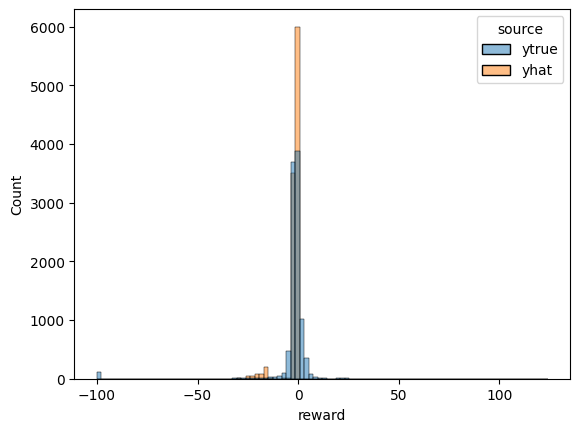

In [51]:
sns.histplot(
    pd.DataFrame({
        "reward": lunar_eval_y.tolist() + np.matmul(lunar_eval_X, lunar_sol).tolist(),
        "source": ["ytrue"]*len(lunar_eval_y) + ["yhat"]*len(lunar_eval_X)
    }),
    x="reward",
    hue="source",
    bins=100
)

In [52]:
rmse(
    v_pred=np.matmul(lunar_eval_X, lunar_sol), 
    v_true=gw_eval_y,
    axis=0
)

9.473140314593916